In [522]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence, load_img, img_to_array
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing import image
import os
import numpy as np
import matplotlib.pyplot as plt

# Set up data directories
train_dir = 'img/asl_alphabet_train'  # Replace with the path to your training data
test_dir = 'img/asl_alphabet_test'       # Replace with the path to your test data


In [495]:
class CustomPreprocessImage(Sequence):
    def __init__(self, directory, classes, images_per_class, split, target_size=(150, 150), batch_size=32, remove_images=dict()):
        self.directory = directory
        self.classes = classes
        self.images_per_class = images_per_class
        self.target_size = target_size
        self.batch_size = batch_size
        self.filepaths = []
        self.labels = []
        self.split = split
        self.selected_images = dict()
        self.remove_images = remove_images
        self._initialize()
        
    def _initialize(self):
        for class_name in self.classes:
            class_dir = os.path.join(self.directory, class_name)
            class_image_files = os.listdir(class_dir)
            class_index = self.classes.index(class_name)
           
            if self.remove_images and self.remove_images[class_index]:
                class_image_files = list(set(class_image_files).difference(self.remove_images[class_index]))
                
            np.random.shuffle(class_image_files)
            
            if 0.0 < self.images_per_class and self.images_per_class <= 1.0:
                self.images_per_class = int(self.images_per_class * len(class_image_files))
            if self.images_per_class <= len(class_image_files):
                self.selected_images[class_index] = class_image_files[:self.images_per_class]
            else:
                self.selected_images[class_index] = class_image_files
                    
            for img_name in self.selected_images[class_index]:
                self.filepaths.append(os.path.join(class_dir, img_name))
                self.labels.append(class_index)
                

        self.filepaths = np.array(self.filepaths)
        self.labels = np.array(self.labels)
    
    def __len__(self):
        return int(np.ceil(len(self.filepaths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.filepaths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        for img_path in batch_x:
            img = load_img(img_path, target_size=self.target_size)
            img_array = img_to_array(img)
            images.append(img_array)

        images = np.array(images).astype('float32') / 255.0
        labels = np.array(batch_y)

        return images, labels
    
     
def CustomImageTrainTestSplit(directory, classes, tests_per_class, validation_per_class, target_size=(150, 150), batch_size=32):
    train = CustomPreprocessImage(directory, classes, images_per_class = tests_per_class, 
                                  target_size=(150, 150), batch_size=32, split='train')
    test = CustomPreprocessImage(directory, classes, images_per_class = validation_per_class, 
                                 target_size=(150, 150), batch_size=32, split='test', remove_images = train.selected_images)
    return train, test
        

In [507]:
class_names = os.listdir(train_dir)
class_names.pop(0)
tests_per_class = 100
validation_per_class = 50
num_classes = len(class_names)

train, validation = CustomImageTrainTestSplit(directory=train_dir, classes=class_names, 
                                              tests_per_class = tests_per_class, 
                                              validation_per_class = validation_per_class)
print("Training Samples = {} ".format(len(train.labels)))
print("Validation Samples = {} ".format(len(validation.labels)))

Training Samples = 2900 
Validation Samples = 1450 


In [505]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(29, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [509]:
model.fit(train, validation_data=validation, epochs=10, verbose=True, batch_size=32)


Epoch 1/10
91/91 [==============================] - 86s 950ms/step - loss: 3.3701 - accuracy: 0.0121 - val_loss: 3.3653 - val_accuracy: 0.0479
Epoch 2/10
91/91 [==============================] - 78s 857ms/step - loss: 3.3817 - accuracy: 0.0279 - val_loss: 3.3364 - val_accuracy: 0.0479
Epoch 3/10
91/91 [==============================] - 86s 945ms/step - loss: 3.3802 - accuracy: 0.0555 - val_loss: 3.3290 - val_accuracy: 0.0776
Epoch 4/10
91/91 [==============================] - 86s 947ms/step - loss: 3.2762 - accuracy: 0.0541 - val_loss: 3.1679 - val_accuracy: 0.1241
Epoch 5/10
91/91 [==============================] - 82s 897ms/step - loss: 3.0867 - accuracy: 0.1372 - val_loss: 2.9341 - val_accuracy: 0.1855
Epoch 6/10
91/91 [==============================] - 83s 914ms/step - loss: 2.7264 - accuracy: 0.2307 - val_loss: 2.5467 - val_accuracy: 0.3107
Epoch 7/10
91/91 [==============================] - 108s 1s/step - loss: 2.2551 - accuracy: 0.3593 - val_loss: 2.2015 - val_accuracy: 0.3655
E

In [282]:
y_test = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 28 images belonging to 1 classes.


In [468]:
model.predict(y_test)

1/1 [==============================] - 0s 328ms/step


array([[3.43400985e-02, 7.27248902e-04, 3.87707123e-11, 4.63752440e-06,
        6.19937282e-07, 1.79245262e-06, 6.35703351e-15, 4.32891510e-02,
        4.60696446e-11, 1.45932431e-08, 2.34204663e-07, 9.86523571e-11,
        7.72620842e-05, 2.31407977e-08, 2.19484809e-06, 2.41918208e-10,
        2.06812168e-04, 7.07004039e-11, 3.31824559e-08, 2.81440914e-01,
        6.57147253e-12, 7.03438210e-11, 2.17074245e-01, 1.15847030e-08,
        1.08336986e-04, 5.74897734e-11, 4.22693253e-01, 3.31022893e-05,
        5.07847896e-11],
       [1.41420903e-11, 4.73052413e-12, 4.26115865e-10, 1.61576406e-06,
        2.19623297e-09, 1.39550216e-09, 4.22224611e-09, 5.21059889e-08,
        1.95980510e-06, 1.47278274e-06, 3.53280548e-03, 4.31454421e-11,
        3.19918814e-10, 1.45886273e-13, 3.34354350e-10, 2.39257059e-09,
        1.36292397e-06, 4.31060032e-09, 1.89482097e-09, 5.96548310e-13,
        1.47882794e-15, 1.55818067e-11, 8.42356920e-01, 1.54102847e-01,
        4.97074812e-11, 1.98887835e-13,

In [535]:
def predict_image(image_path, model):
    img = image.load_img(image_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    prediction = model(img_array)
    score = max(prediction)
    
    # Display the image with the predicted label
    plt.imshow(img)
    plt.title(f'Predicted: {class_names[np.argmax(prediction)]} \nImage: {image_path}')
    plt.axis('off')  # Hide axis
    plt.show()
    print("\nThe image is predicted to be '{}' with a {:.2f}% confidence."
        .format(class_names[np.argmax(prediction)], 100 * np.max(score)))
    return prediction

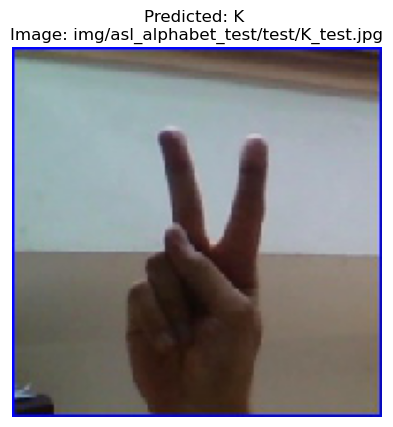


The image is predicted to be 'K' with a 95.30% confidence.


In [539]:
image_path = 'img/asl_alphabet_test/test/K_test.jpg'
prediction = predict_image(image_path, model)
predicted_class = np.argmax(prediction[0]) # get max's index